In [3]:
# Load
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import zoom
from src.data.dataset import Dataset
from src.modules.lightning_cnn import LitCNN
from src.utils.optimization import Optimization
import nibabel as nib
from torch.utils.data import TensorDataset

MODEL_PATH = r"/home/ubuntu/giorgio/v311/lightning_logs/brain_model/version_111/checkpoints/epoch=29-step=180.ckpt"
IMG_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/goundtruth_testBosisio/goundtruth/sub-010_dseg_warped_0.5mm.nii.gz"

def resize(array: np.array,) :
    target_shape = (128, 128, 128)

    # Calculate zoom factors
    original_shape = array.shape
    zoom_factors = [t / o for t, o in zip(target_shape, original_shape)]

    # Resize the array using nearest-neighbor interpolation
    resized_array = zoom(array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation
    return resized_array

def reshape_output(
    y_hat: torch.Tensor,
) -> torch.Tensor:
    """
    Reshape the output tensor of the 5_355 model to the 90 model.

    Parameters:
    - y_hat (torch.Tensor): Predicted tensor from the 5_355 model.
    - patient_idx (int): Index of the patient in the test set, to be reshaped.

    Returns:
    - torch.Tensor: output tensor with resized shape.

    """
    y_hat_new = y_hat.cpu().data.numpy()
    y_hat_new = y_hat_new.reshape(10,3)

    return y_hat_new

In [4]:
def import_img(IMG_PATH:str,):
    raw_img = nib.load(IMG_PATH)
    my_img = raw_img.get_fdata()
    resized_img = resize(my_img)
    resized_img=np.expand_dims(resized_img, axis=0)
    resized_img=np.expand_dims(resized_img, axis=0)
# Verify the result
    print(resized_img.shape)
    return resized_img

resized_img = import_img(IMG_PATH) 

(1, 1, 128, 128, 128)


In [5]:
(brains,
    y_reg,
    predict_index,
) = tuple(
    map(
        torch.Tensor,
        (
            resized_img,
            [np.ones(30)],
            1,
        ),
    )
)
pred_dataset = TensorDataset(
    brains,
    y_reg,
    predict_index,
)

dataset = pred_dataset
lightning_cnn = LitCNN.load_from_checkpoint(checkpoint_path=MODEL_PATH)

prediction_loader = DataLoader(
    dataset,
    num_workers=0,
)

trainer = Trainer(logger=False)

/tmp/ipykernel_2309/1232462241.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  ) = tuple(


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
biometry=trainer.predict(lightning_cnn, dataloaders=prediction_loader, return_predictions=True)
biometry=reshape_output(biometry[0])

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ubuntu/giorgio/v311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


### Per visualizzare i risultati

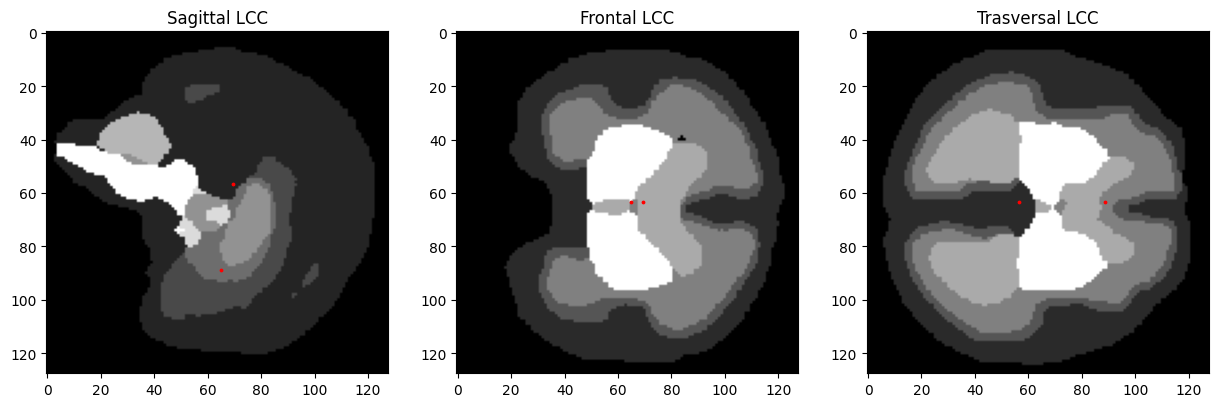

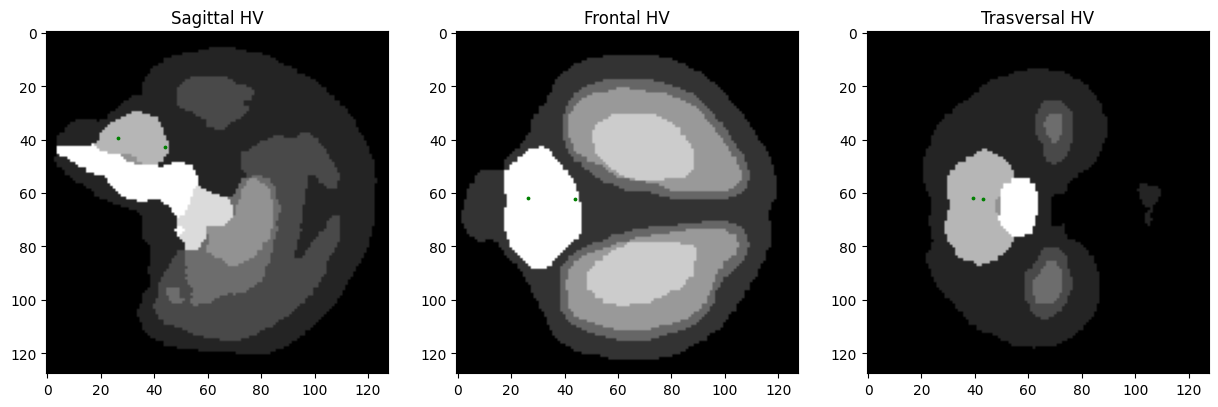

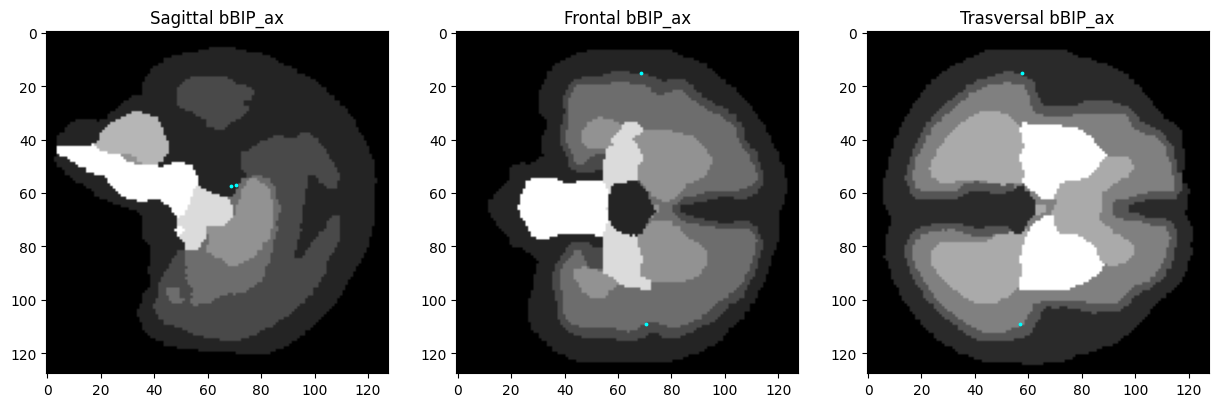

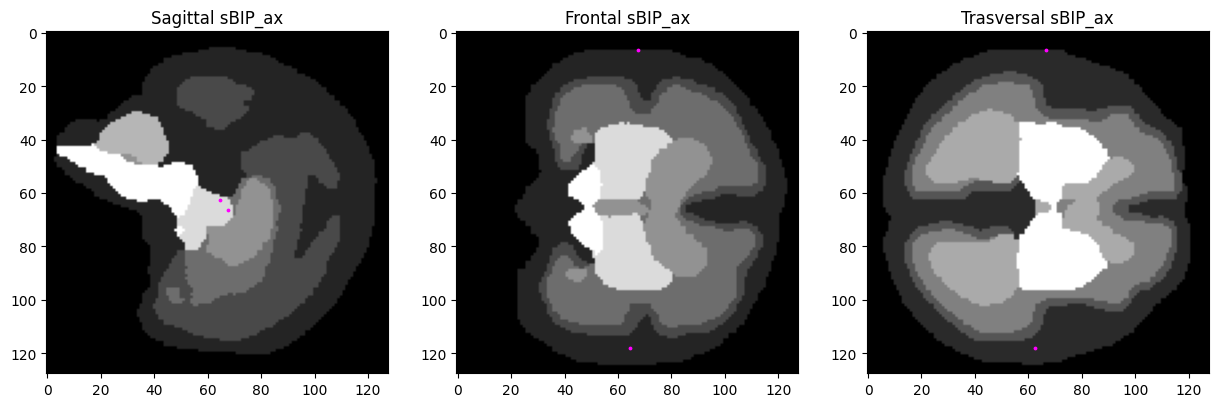

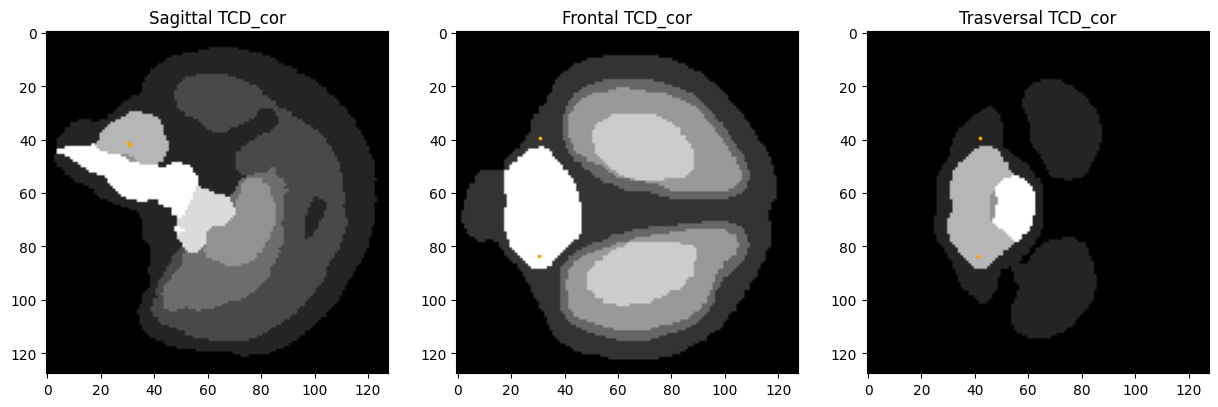

In [23]:
import matplotlib.pyplot as plt

opti= Optimization(resized_img, biometry,)
x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_img[0][0]

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

### Fase di ottimizzazione

### Ora lavoro con la maschera prevista

In [24]:
IMG_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/goundtruth_testBosisio/goundtruth/sub-026_dseg_warped_0.5mm.nii.gz"

In [25]:
resized_img = import_img(IMG_PATH) 

(1, 1, 128, 128, 128)


In [26]:
(brains,
    y_reg,
    predict_index,
) = tuple(
    map(
        torch.Tensor,
        (
            resized_img,
            [np.ones(30)],
            1,
        ),
    )
)
pred_dataset = TensorDataset(
    brains,
    y_reg,
    predict_index,
)

dataset = pred_dataset
lightning_cnn = LitCNN.load_from_checkpoint(checkpoint_path=MODEL_PATH)

prediction_loader = DataLoader(
    dataset,
    num_workers=0,
)

trainer = Trainer(logger=False)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
biometry=trainer.predict(lightning_cnn, dataloaders=prediction_loader, return_predictions=True)
biometry=reshape_output(biometry[0])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.15it/s]


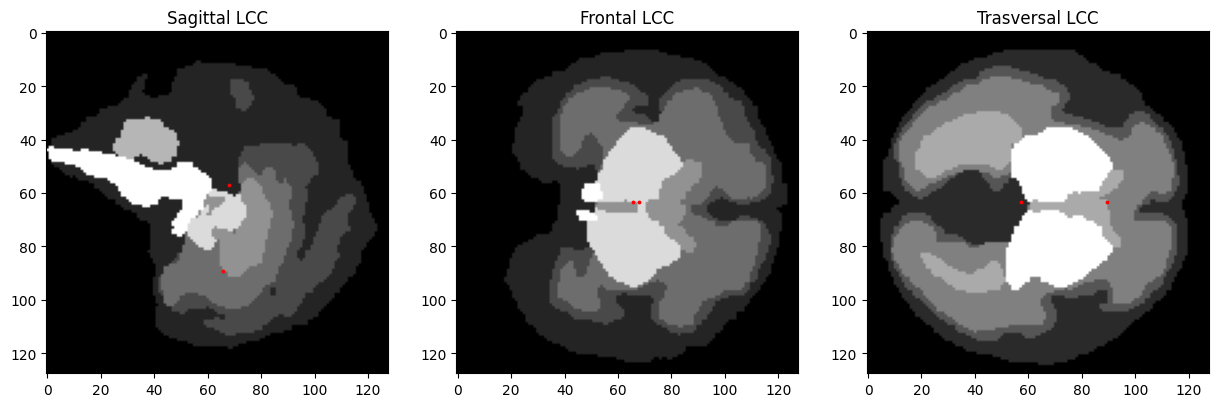

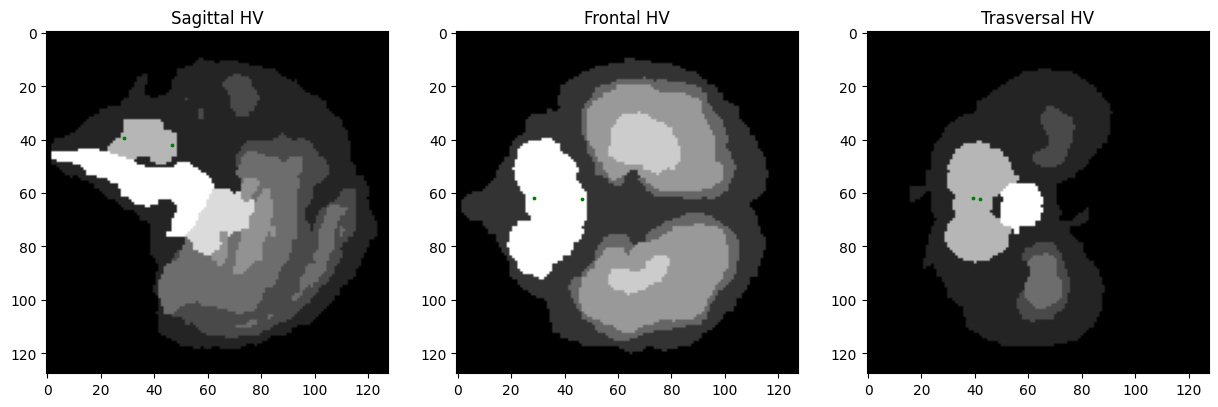

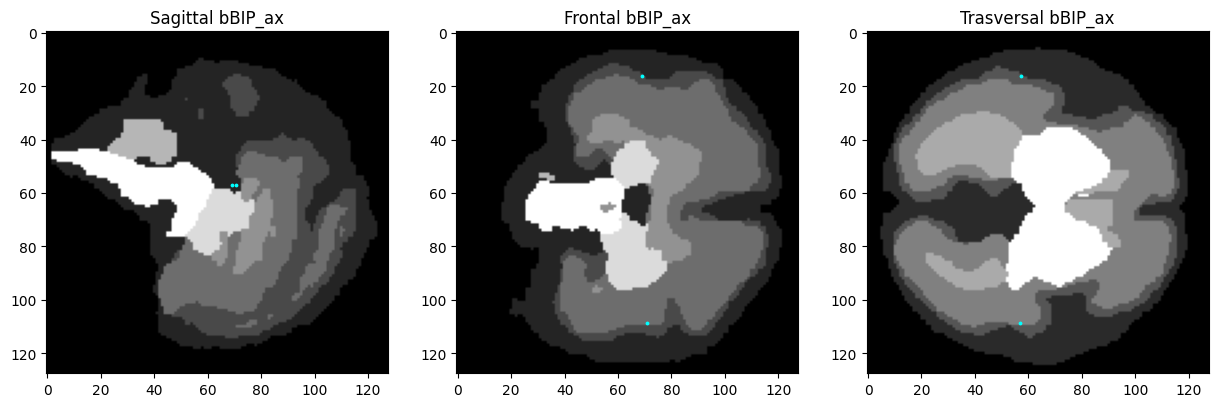

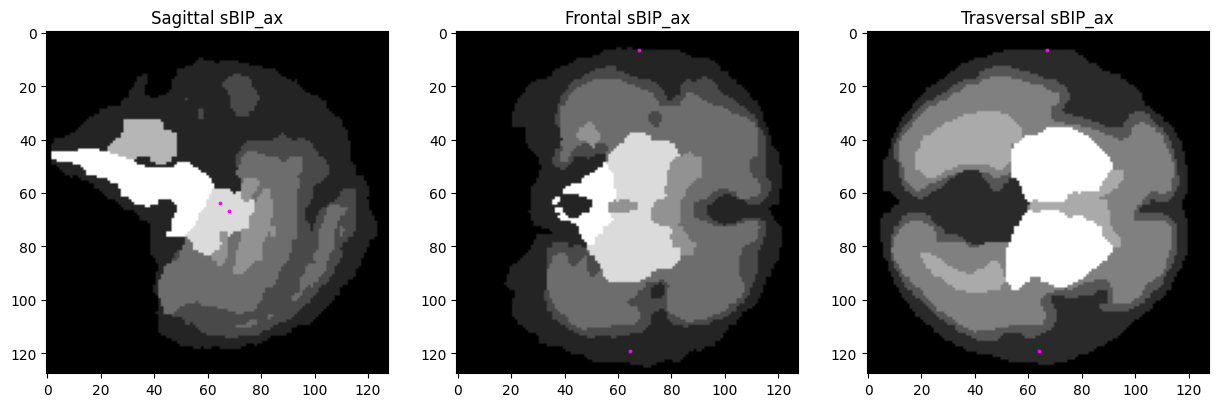

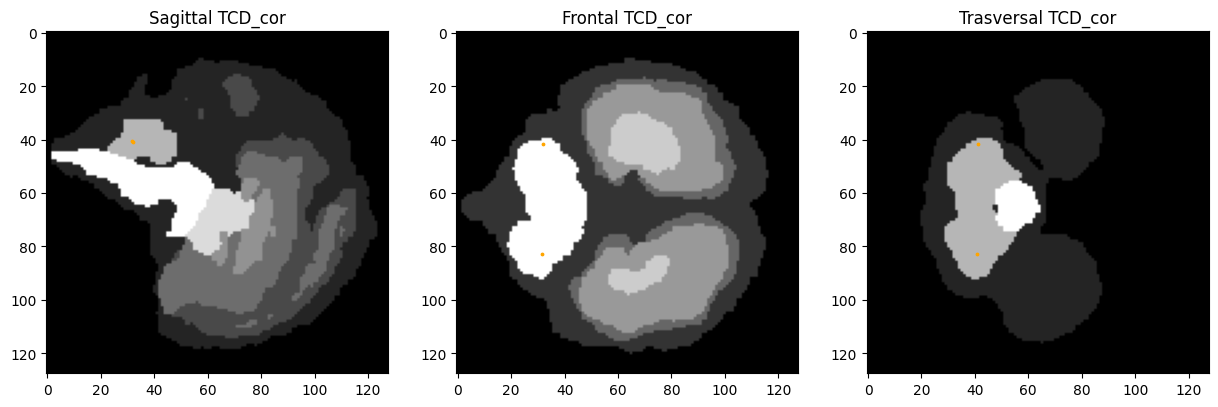

In [28]:
import matplotlib.pyplot as plt

x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_img[0][0]

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()